In [1]:
from model import unet_model
import tensorflow as tf
import glob
from functools import partial
from utils import dice_coef, dice_bce_loss
import matplotlib
import numpy as np

2023-11-19 19:57:31.653705: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [2]:
tf.config.list_physical_devices()

2023-11-19 19:57:35.077691: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2023-11-19 19:57:35.081950: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2023-11-19 19:57:35.081987: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.


[PhysicalDevice(name='/physical_device:CPU:0', device_type='CPU'),
 PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

In [3]:
#Зададим размер batch и размер изображения
BATCH_SIZE = 16
IMG_SHAPE  = (256, 256)
OUTPUT_SIZE = (960, 1280)

CLASSES = 8

#Цвета для отображения сегментации
Colors = ['black',
          'blue',
          'green',
          'sky',
          'red',
          'pink',
          'yellow',
          'white']
rgb_colors = [(0, 0, 0),
              (0, 0, 1),
              (0, 1, 1),
              (0, 1, 1),
              (1, 0, 0),
              (1, 0, 1),
              (1, 1, 0),
              (1, 1, 1)]

original = tf.constant(rgb_colors)
original = tf.cast(original, tf.float32)
rgb_colors_tf = tf.image.rgb_to_grayscale(original)
rgb_colors_converted= rgb_colors_tf.numpy().reshape(-1,).tolist()

2023-11-19 19:57:35.097959: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2023-11-19 19:57:35.098056: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2023-11-19 19:57:35.098081: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2023-11-19 19:57:35.211465: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2023-11-19 19:57:35.211510: I tensorflow/compile

In [4]:
images = sorted(glob.glob('./dataset/images/*.jpg'))
masks = sorted(glob.glob('./dataset/masks/*.bmp'))

In [5]:
#Функция для загрузки изображения
def load_img(image, mask):
    #Загружаем и препроцессим изображения
    image = tf.io.read_file(image)
    image = tf.io.decode_jpeg(image)
    image = tf.image.resize(image, IMG_SHAPE)
    image = tf.image.convert_image_dtype(image, tf.float32)
    image = image / 255.0

    #Загружаем и препроцессим маски изображений
    mask = tf.io.read_file(mask)
    mask = tf.io.decode_bmp(mask)
    mask = tf.image.resize(mask, IMG_SHAPE)
    mask = tf.image.convert_image_dtype(mask, tf.float32)
    mask = mask / 255.
    mask = tf.image.rgb_to_grayscale(mask)

    #Сохраним маски для каждого класса
    masks = []
    for color in rgb_colors_converted:
        masks.append(tf.where(tf.equal(mask, float(color)), 1.0, 0.0))
    masks = tf.stack(masks, axis=2)
    masks = tf.reshape(masks, IMG_SHAPE + (CLASSES,))
    return image, masks

#Аугментация изобажений
def aug_img(image, masks):
    random_crop = tf.random.uniform((), 0.3, 1)
    image = tf.image.central_crop(image, random_crop)
    masks = tf.image.central_crop(masks, random_crop)
    random_flip = tf.random.uniform((), 0, 1)
    if random_flip >= 0.5:
        image = tf.image.flip_left_right(image)
        masks = tf.image.flip_left_right(masks)
    image = tf.image.resize(image, IMG_SHAPE)
    masks = tf.image.resize(masks, IMG_SHAPE)
    return image, masks

In [6]:
#Формируем датасет
dataset = tf.data.Dataset.zip((tf.data.Dataset.from_tensor_slices(images),
                               tf.data.Dataset.from_tensor_slices(masks)))

#Загружаем дату
dataset = dataset.map(load_img, num_parallel_calls=tf.data.AUTOTUNE)

#Аугментация (увеличим датасет в 50 раз)
# dataset = dataset.repeat(50)
# dataset = dataset.map(aug_img, num_parallel_calls=tf.data.AUTOTUNE)

In [7]:
#Размер train выборки
train_size = 1200

#Делим на train и test
train_dataset = dataset.take(train_size).cache()
test_dataset = dataset.skip(train_size).take(len(dataset) - train_size).cache()

train_dataset = train_dataset.batch(BATCH_SIZE)
test_dataset = test_dataset.batch(BATCH_SIZE)

In [8]:
#Функция для подсчёта DICE коэффициента
def dice_coef(y_pred, y_true):
    y_pred = tf.unstack(y_pred, axis=3)
    y_true = tf.unstack(y_true, axis=3)
    dice_summ = 0

    for i, (a_y_pred, b_y_true) in enumerate(zip(y_pred, y_true)):
        dice_calculate = (2 * tf.math.reduce_sum(a_y_pred * b_y_true) + 1) /\
         (tf.math.reduce_sum(a_y_pred + b_y_true) + 1)

        dice_summ += dice_calculate
    avg_dice = dice_summ/CLASSES
    return avg_dice


#Функция для подсчета DICE loss
def dice_loss(y_pred, y_true):
    d_loss = 1 - dice_coef(y_pred, y_true)
    return d_loss


#binary_crossentropy - дает хорошую сходимость модели при сбалансированном наборе данных
#DICE - хорошо в задачах сегментации но плохая сходимость
#Плохо сбалансированные данные, но хорошие реузьтаты:
# Binary crossentropy + 0.25 * DICE

def dice_bce_loss(y_pred, y_true):
    total_loss = 0.25 * dice_loss(y_pred, y_true) + tf.keras.losses.binary_crossentropy(y_pred, y_true)
    return total_loss

In [9]:
#Иницилизируем модель
model = unet_model(IMG_SHAPE, CLASSES)

# tf.keras.utils.plot_model(model, show_shapes=True)
#Компилируем модель
model.compile(optimizer='adam',
                  loss=[dice_bce_loss],
                  metrics=[dice_coef])

In [13]:
EPOCHS = 50

#Обучение
model.fit(train_dataset,
          # validation_data=test_dataset,
          epochs=EPOCHS,
          initial_epoch=0)

Epoch 1/50


2023-11-19 18:59:45.454763: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape inmodel/dropout/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer
2023-11-19 18:59:46.006773: I tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:432] Loaded cuDNN version 8600
2023-11-19 18:59:48.008374: I tensorflow/compiler/xla/service/service.cc:168] XLA service 0x7fea01ad8d10 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2023-11-19 18:59:48.008418: I tensorflow/compiler/xla/service/service.cc:176]   StreamExecutor device (0): NVIDIA GeForce GTX 1070, Compute Capability 6.1
2023-11-19 18:59:48.040959: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:255] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2023-11-19 18:59:48.336164: I ./tensorflow/compiler/jit/device_compiler.h:186] Compiled 

75/75 [==============================] - 32s 279ms/step - loss: 0.7310 - dice_coef: 0.1984
Epoch 2/50
75/75 [==============================] - 21s 284ms/step - loss: 0.4429 - dice_coef: 0.1933
Epoch 3/50
75/75 [==============================] - 21s 284ms/step - loss: 0.4306 - dice_coef: 0.1910
Epoch 4/50
75/75 [==============================] - 21s 282ms/step - loss: 0.4288 - dice_coef: 0.1931
Epoch 5/50
75/75 [==============================] - 21s 282ms/step - loss: 0.4282 - dice_coef: 0.1952
Epoch 6/50
75/75 [==============================] - 21s 283ms/step - loss: 0.4241 - dice_coef: 0.1994
Epoch 7/50
75/75 [==============================] - 21s 282ms/step - loss: 0.4176 - dice_coef: 0.2077
Epoch 8/50
75/75 [==============================] - 21s 282ms/step - loss: 0.4123 - dice_coef: 0.2144
Epoch 9/50
75/75 [==============================] - 21s 284ms/step - loss: 0.4077 - dice_coef: 0.2194
Epoch 10/50
75/75 [==============================] - 21s 283ms/step - loss: 0.4034 - dice_coe

In [15]:
model.save('./checkpoints/checkpoint_best_unet_like_model_50epochs')

INFO:tensorflow:Assets written to: ./checkpoints/checkpoint_best_unet_like_model_50epochs/assets


INFO:tensorflow:Assets written to: ./checkpoints/checkpoint_best_unet_like_model_50epochs/assets


In [32]:
model.save('./checkpoints/model_50epochs.keras')

In [10]:
model = tf.keras.models.load_model('./checkpoints/checkpoint_best_unet_like_model_50epochs', custom_objects={"dice_coef": dice_coef, "dice_bce_loss":dice_bce_loss})

In [54]:
my_test = iter(test_dataset)

In [ ]:
# Преобразование Датасета
test_dataset_ex = None
test_dataset_img = None

for el in test_dataset_list:
    test_dataset_img = np.append(test_dataset_img, [el[0]], axis=0) if test_dataset_img is not None else np.array([el[0]])
    test_dataset_ex = np.append(test_dataset_ex, [el[1]], axis=0) if test_dataset_ex is not None else np.array([el[1]])

In [100]:
test_results = model.predict(test_dataset_img)

11/11 [==============================] - 3s 132ms/step


In [101]:
test_results.shape

(325, 256, 256, 8)

In [14]:
iou_data = np.zeros((test_results.shape[0], test_results.shape[-1]))

smooth=1

for img, idx in zip(test_dataset.unbatch(), range(test_results.shape[0])):  # Итерация по изображениям
    y = img[1]    
    for f in range(test_results.shape[-1]):  # Итерация по каналам
        # iou_data = np.append(iou_data, IoU_calc(y[..., f].numpy(), test_results[idx][..., f]))
        
        flat_pred = y[..., f].numpy().ravel()
        flat_target = test_results[idx][..., f].ravel()
        
        intersection = (flat_pred * flat_target).sum()
        total = (flat_pred + flat_target).sum()
        union = total - intersection

        iou = (intersection + smooth) / (union + smooth)
        iou_data[idx, f] = iou

In [15]:
iou_data.mean()

0.28855977255128085

In [16]:
iou_data.mean(axis=0).reshape(-1,1)

array([[0.52941222],
       [0.17557804],
       [0.13211476],
       [0.13594442],
       [0.95223826],
       [0.14765447],
       [0.08323689],
       [0.15229912]])

In [17]:
import matplotlib.pyplot as plt
def img_show(*images, **kwargs):
    fig, axs = plt.subplots(1, len(images), figsize=(18, 5))
    for ax, img in zip(axs, images):
        ax.imshow(img, **kwargs)
    plt.show()

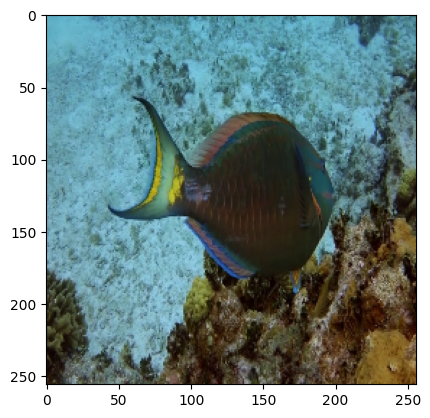

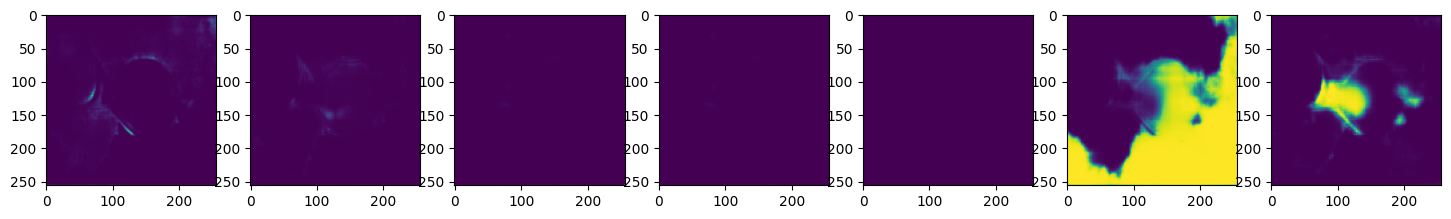

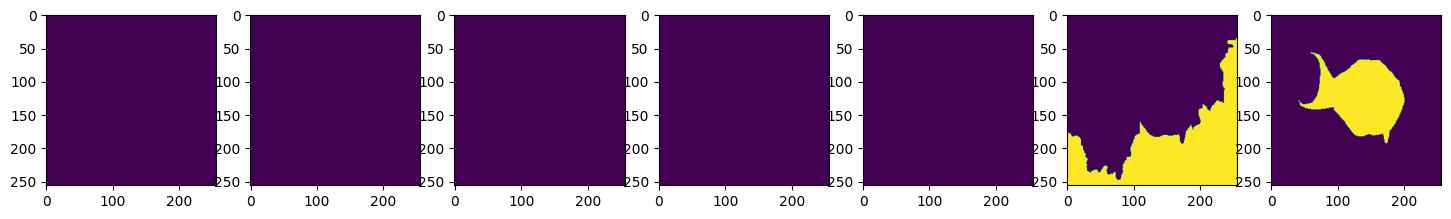

In [108]:
img_index = 10
plt.imshow(test_dataset_img[img_index], )
img_show(*[test_results[img_index][..., i] for i in range(7)])
img_show(*[test_dataset_ex[img_index][..., i] for i in range(7)])